<h1 align ="center"> REST API Grounding Enhanchment Samples</h1>
<hr>
   
# Chat Completions

In [1]:
import json
import os
import requests
import base64
import re
import matplotlib.pyplot as plt
import textwrap
import random
from PIL import Image, ImageDraw, ImageFont

### Setup Parameters


Here we will load the configurations from _config.json_ file to setup deployment_name, openai_api_base, openai_api_key and openai_api_version.

In [2]:
# Load config values
with open(r'config.json') as config_file:
    config_details = json.load(config_file)
    
# Setting up the deployment name
deployment_name = config_details['GPT-4V_MODEL']

# The base URL for your Azure OpenAI resource. e.g. "https://<your resource name>.openai.azure.com"
openai_api_base = config_details['OPENAI_API_BASE']

# The API key for your Azure OpenAI resource.
openai_api_key = os.getenv("OPENAI_API_KEY")

# Currently OPENAI API have the following versions available: 2022-12-01. All versions follow the YYYY-MM-DD date structure.
openai_api_version = config_details['OPENAI_API_VERSION']

The image showcases the interior of a luxurious, well-lit shopping mall featuring a grand, marble staircase with a sleek dark wood and metal railing that leads to the second floor.
The flooring displays an intricate design with a mix of marble and dark tiles creating a geometric pattern.
On the first floor, there are contemporary black leather seating areas with cushions, and elegant black tables, positioned near a series of upscale retail stores with glass entrances and sophisticated displays.
The ceiling, adorned with a geometric glass design, allows natural light to flood the space, illuminating the area and enhancing the opulent atmosphere.


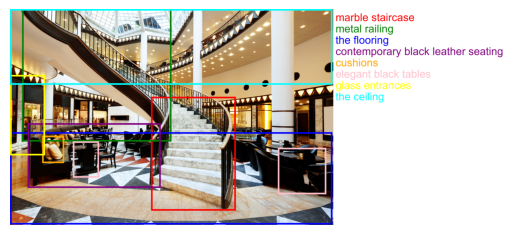

In [5]:
#Image Description Assistant
image_file_path = "../../common/images/ImageDescriptionAssistant.jpg"  # Update with your image path
sys_message = "You are an AI assistant that helps people craft a clear and detailed sentence that describes the content depicted in an image."
user_prompt = "Describe image"

# Encode the image in base64
with open(image_file_path, 'rb') as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode('ascii')

# Construct the API request URL
api_url = f"{openai_api_base}/openai/deployments/{deployment_name}/extensions/chat/completions?api-version={openai_api_version}"

# Including the api-key in HTTP headers
headers = {
    "Content-Type": "application/json",
    "api-key": openai_api_key,
}

# Payload for the request
payload = {
  "enhancements": {
    "grounding": {
      "enabled": True   # Enable grounding enhancement
    },
  },
  "messages": [
    {
      "role": "system",
      "content": [
        sys_message
      ]
    },
    {
      "role": "user",
      "content": [
        user_prompt, # Pass the prompt
        {
          "image": encoded_image  #Pass the encoded image
        }
      ]
    }
  ],
  "temperature": 0.7,
  "top_p": 0.95,
  "max_tokens": 800
}

def random_color():
    """ Generate a random color. """
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

def draw_groundings(image_path, groundings):
    # Load the image
    original_image = Image.open(image_path)
    width, height = original_image.size

    box_width = max(2, width // 200)
    font_size = max(15, height // 20)

    extended_width = width + 1500  # More space for text
    image = Image.new('RGB', (extended_width, height), 'white')
    image.paste(original_image, (0, 0))

    draw = ImageDraw.Draw(image)

    predefined_colors = ['red', 'green', 'blue', 'purple', 'orange', 'pink', 'yellow', 'cyan']
    text_color_map = {}  # Dictionary to map text to colors
    text_x = width + 20  # Starting just after the original image
    text_y = 20  # Initial vertical position

    # Iterate over each grounding in the data
    for grounding in groundings:
        text = grounding['text']
        polygon = grounding['polygon']

        if text not in text_color_map:
            if predefined_colors:
                text_color_map[text] = predefined_colors.pop(0)
            else:
                text_color_map[text] = random_color()

        color = text_color_map[text]
        absolute_polygon = [(p['x'] * width, p['y'] * height) for p in polygon]

        bounding_box = [min(p[0] for p in absolute_polygon), min(p[1] for p in absolute_polygon),
                        max(p[0] for p in absolute_polygon), max(p[1] for p in absolute_polygon)]
        draw.rectangle(bounding_box, outline=color, width=box_width)

    # Draw the text on the extended right side of the image
    for text, color in text_color_map.items():
        try:
            font = ImageFont.truetype("arial.ttf", font_size)
        except IOError:
            font = ImageFont.load_default()

        # Text wrapping
        wrapped_text = textwrap.fill(text, width=40)  # Adjust width as needed
        for line in wrapped_text.split('\n'):
            if text_y + font_size < height:
                draw.text((text_x, text_y), line, fill=color, font=font)
                text_y += font_size + 5  # Increment y position for next line
            else:
                break  # Stop if there's no more space

    # Save or display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Send the request and handle the response
try:
    response = requests.post(api_url, headers=headers, json=payload)
    response.raise_for_status()  # Raise an error for bad HTTP status codes
    response_content = response.json()
    text = response_content['choices'][0]['message']['content']
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    for sentence in sentences:  # Print the content of the response
        print(sentence)
    draw_groundings(image_file_path,response_content['choices'][0]['enhancements']['grounding']['lines'][0]['spans'])
except requests.RequestException as e:
    raise SystemExit(f"Failed to make the request. Error: {e}")